<a href="https://colab.research.google.com/github/lenakaravaeva/steganography/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Караваева Елена
## Вариант 7

In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import cv2

%matplotlib inline

# Получим из интернета картинку и переведем её в бинарный вид

In [ ]:
def plt_imshow(image):
  print('Data shape:', image.shape)
  print('Data type:',type(image))
  plt.imshow(image, cmap='gray')
  plt.show()

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


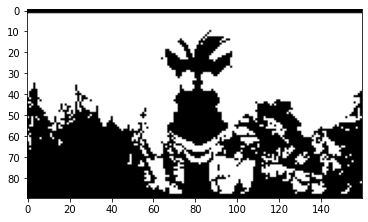

In [ ]:
# read the image file
os.system('curl -O https://i.ytimg.com/vi/zkVGNaneO4s/maxresdefault.jpg')
img = cv2.imread('maxresdefault.jpg', 2)

# Уменьшаем в раз размер картинки
img = cv2.resize(img, (0,0), fx=0.125, fy=0.125) 

# Конвертим в бинарный вид
_, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


  
# from google.colab.patches import cv2_imshow # пользуемся этим, т.к. в колабе не работает # cv2.imshow(bw_img)
# cv2_imshow(binary_image)
plt_imshow(binary_image)

# Переведем строку в массив байтов

In [ ]:
secret_phrase = "Julius Caesar, The Talking Horse - The horse of Alyosha Popovich; born in Novgorod, where he read a lot of books, because he lived in the Church library. He Named himself after the Roman emperor."
print(secret_phrase[0])
print(len(secret_phrase))

J
195


In [ ]:

def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return result

def frombits(bits):
    chars = []
    for b in range(len(bits) // 8):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

In [ ]:
# Закодируем строку в массив битов с помощью функции tobits

secret_phrase_encoded = np.array(tobits(secret_phrase), dtype=np.uint8)
print(secret_phrase_encoded)
print(secret_phrase_encoded.size)
print(type(secret_phrase_encoded)) # ensure it is byte representation)
print(secret_phrase_encoded[1])

[0 1 0 ... 1 1 0]
1560
<class 'numpy.ndarray'>
1


In [ ]:
# Для теста раскодируем массив битов обратно в строку

secret_phrase_decoded_test = frombits(secret_phrase_encoded)
print(secret_phrase_decoded_test)
print(type(secret_phrase_decoded_test)) # ensure it is string representation
del secret_phrase_decoded_test # удаляем переменную, чтобы ниже не воспользоваться ей случайно

Julius Caesar, The Talking Horse - The horse of Alyosha Popovich; born in Novgorod, where he read a lot of books, because he lived in the Church library. He Named himself after the Roman emperor.
<class 'str'>


# Реализуем подготовку к методам DHST/DHSPT.

In [ ]:
N1, N2 = binary_image.shape
Nb = len(secret_phrase_encoded)
replace_matrix_size = 3 # Размер матрицы
print("N1 =", N1, "\nN2 =", N2, "\nNb =", Nb,)

N1 = 90 
N2 = 160 
Nb = 1560


In [ ]:
percent_coding = secret_phrase_encoded.size / ((N1 * N2) / replace_matrix_size**2)  * 100
assert percent_coding < 100, 'Фраза слишком длинна для представленного метода кодирования и представленного изображения'
print("У нас будет закодировано", percent_coding, "% изображения")

У нас будет закодировано 97.5 % изображения


In [ ]:

def get_key(index, N1, N2, v):
  """
  Вычисляет координаты пикселя, в который необходимо положить данные по индексу ключа (при этом окрестность пикселя находится вокруг него)
  Keyword arguments:
    index -- Индекс ключа
    N1 -- Высота исходной картинки
    N2 -- Ширина исходной картинки
    v -- Целое число, во сколько раз будет уменьшена сетка по каждой размерности (по каждой размерности)
  """
  # max1dim = (N1-1) // v + 1 
  # max2dim = (N2-1) // v + 1 
  max1dim = N1 // v
  max2dim = N2 // v

  assert index < max1dim * max2dim, 'Вылетели за границы массива, должно выполняться условие index < max1dim * max2dim'
  return v * (index // max2dim) + 1, v * (index % max2dim) + 1 

get_key(1, 3, 6, replace_matrix_size) # тестовый вызов функции

(1, 4)

# Реализуем предварительно метод DHST (СВИ-5) с генерацией пар чисел на втрое меньшей сетке (не по варианту, просто, мимоходом)

In [ ]:
binary_image_encoded_dhst = binary_image.copy() # Сделаем новый объект, в который будем записывать измененные пиксели

for index in range(Nb):
  n1, n2 = get_key(index, N1, N2, replace_matrix_size)
  binary_image_encoded_dhst[n1,n2] = secret_phrase_encoded[index] * 255  # умножаем на 255 т.к. в binary_image_encoded_dhst яркость задается бинарно или 0 или 255.

Отобразим закодированную методом DHST картинку

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


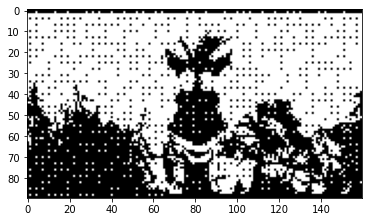

In [ ]:
plt_imshow(binary_image_encoded_dhst)

Посмотрим на разность и исходной картинки и закодированной методом DHST ради интереса

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


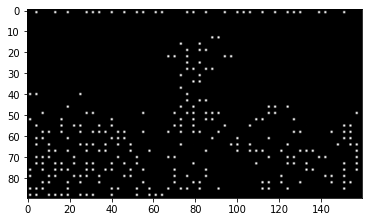

In [ ]:
plt_imshow(abs(binary_image_encoded_dhst - binary_image))

Посмотрим число разных пикселей

In [ ]:
np.sum(abs(binary_image_encoded_dhst - binary_image) / 255) # косвенно это показывает число разных пикселей

277.0392156862745

# Реализуем декодирование после метода DHST из изображения и ключа (не по варианту, просто, мимоходом) (Но после реализации DHSPT мы можем понять, что декодировани для метода DHST и DHSPT совершенно одинаковое)

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


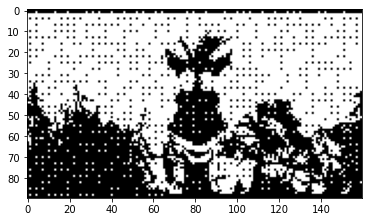

In [ ]:
plt_imshow(binary_image_encoded_dhst)

In [ ]:
binary_image_decoded_dhst = binary_image_encoded_dhst.copy() # Сделаем новый объект, в который будем записывать декодированные пиксели
secret_phrase_decoded_dhst_bits = np.zeros(Nb, dtype=np.uint8)
# print(secret_phrase_decoded.shape)

for index in range(Nb):
  n1, n2 = get_key(index, N1, N2, replace_matrix_size) # индек
  secret_phrase_decoded_dhst_bits[index] = binary_image_encoded_dhst[n1,n2] // 255  # достаем значение по индексу [n1,n2] из картинки и перекладываем в secret_phrase_decoded_dhst_bits
print(secret_phrase_decoded_dhst_bits)

[0 1 0 ... 1 1 0]


In [ ]:
secret_phrase_decoded_dhst = frombits(secret_phrase_decoded_dhst_bits) # из массива битов декодируем строку
print(secret_phrase_decoded_dhst)

Julius Caesar, The Talking Horse - The horse of Alyosha Popovich; born in Novgorod, where he read a lot of books, because he lived in the Church library. He Named himself after the Roman emperor.


Ура! Мы смогли декодировать текст!

# Реализуем метод DHSPT с помощью компенсацией искажений

Компенсирующий пиксель выбирается на основе матрицы весов.

Размер окрестности, в которой будет определена матрица весов - 3x3.

Способ генерации ключа - по формуле (4.6) - генерация координат сетки на втрое меньшей сетке

In [ ]:
binary_image_encoded_dhspt = binary_image.copy() # Сделаем новый объект, в который будем записывать измененные пиксели
w = [[1, 2, 1], [2, 0, 2], [1, 2, 1]] # веса для метода DHSPT для матрицы 3x3 (при replace_matrix_size=3)
assert replace_matrix_size == 3, "Данный код необходимо модицировать, указывать матрицу весов итп для значений replace_matrix_size отличных от 3"

for index in range(Nb):
  n1, n2 = get_key(index, N1, N2, replace_matrix_size)
  insert_pixel = secret_phrase_encoded[index] * 255 # умножаем на 255 т.к. приняла решение бинарность кодировать 0 и 255, а в secret_phrase_encoded лежит 0 или 1
  binary_image_encoded_dhspt[n1,n2] = insert_pixel  # кодируем данные в пиксель в этой строке
 
  sliding_window = binary_image[n1-1 : n1+2, n2-1 : n2+2]
  mask_equality_sliding_window_and_insert_pixel = np.isin(sliding_window, insert_pixel)

  if (np.sum(mask_equality_sliding_window_and_insert_pixel) - mask_equality_sliding_window_and_insert_pixel[1,1]) != 0:  # Если есть среди нашего скользящего окна sliding_window есть элементы, равные insert_pixel, иначе компенсацию просто не производим
    pre_mask = w*mask_equality_sliding_window_and_insert_pixel # если пиксель нельзя не надо менять, то в w мы записали 0 и полученный массив записали в pre_mask
    i_compens_pixel_arr, j_compens_pixel_arr = np.where(pre_mask == 2)  # достаём индексы элементов в pre_mask, которые равны 2 
    if i_compens_pixel_arr.size == 0: # Т.е. нет в pre_mask элементов со значением 2
      i_compens_pixel_arr, j_compens_pixel_arr = np.where(pre_mask == 1) # достаём индексы элементов в pre_mask, которые равны 1 
      if i_compens_pixel_arr.size == 0: # Т.е. нет в pre_mask элементов со значением 1
        print(index, "Если вы видите этот лог, то значит, в коде есть ошибка :)")
    
    i_compens_pixel = i_compens_pixel_arr[0]
    j_compens_pixel = j_compens_pixel_arr[0]
    inverse_insert_pixel = 255 if insert_pixel==0 else 0  # инвертируем значение insert_pixel
    binary_image_encoded_dhspt[n1+i_compens_pixel-1,n2+j_compens_pixel-1] = inverse_insert_pixel
  
  
  # Для дебага код дальше в этой ячейке:  
  # if index == 993:
  #   print(insert_pixel)
  #   print(sliding_window)
  #   print(mask_equality_sliding_window_and_insert_pixel)
  #   print(w * mask_equality_sliding_window_and_insert_pixel)

In [ ]:
# Тестировала слайсы в питоне
# w_test = np.array([[1, 2, 1, 1], [2, 0, 2, 1], [1, 2, 1, 1]])
# n_test = 1
# w_test[n_test-1 : n_test+2, n_test-1 : n_test+2]

In [ ]:
# Тестировала np.where
# w_test = np.array([[1, 2, 1, 3], [2, 0, 2, 1], [1, 2, 1, 1]])

# i,j = np.where(w_test == 4)
# i.size

Отобразим закодированную методом DHSPT картинку 

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


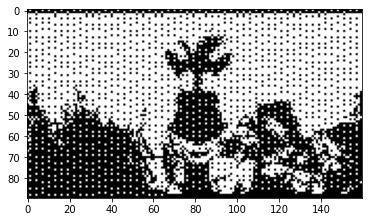

In [ ]:
plt_imshow(binary_image_encoded_dhspt)

Посмотрим на разность и исходной картинки и закодированной методом DHSPT ради интереса

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


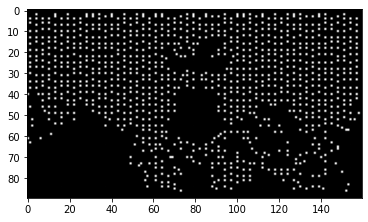

In [ ]:
plt_imshow(abs(binary_image - binary_image_encoded_dhspt))

Посмотрим на разность DHSPT и DHST:

Data shape: (90, 160)
Data type: <class 'numpy.ndarray'>


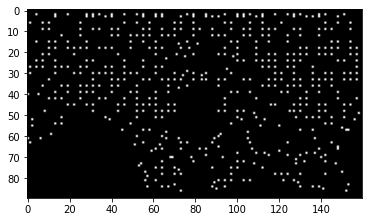

In [ ]:
plt_imshow(abs(binary_image_encoded_dhst - binary_image_encoded_dhspt))

 # Реализуем декодирование после метода DHSPT из изображения и ключа

In [ ]:
binary_image_decoded = binary_image_encoded_dhspt.copy() # Сделаем новый объект, в который будем записывать декодированные пиксели
secret_phrase_decoded_dhspt_bits = np.zeros(Nb, dtype=np.uint8)
# print(secret_phrase_decoded.shape)

for index in range(Nb):
  n1, n2 = get_key(index, N1, N2, replace_matrix_size)
  secret_phrase_decoded_dhspt_bits[index] = binary_image_encoded_dhspt[n1,n2] // 255  # достаем значение по индексу [n1,n2] из картинки и перекладываем в secret_phrase_decoded_dhspt_bits
print(secret_phrase_decoded_dhspt_bits)

[0 1 0 ... 1 1 0]


In [ ]:
secret_phrase_dhspt_decoded = frombits(secret_phrase_decoded_dhspt_bits) # из массива битов декодируем строку
print(secret_phrase_dhspt_decoded)

Julius Caesar, The Talking Horse - The horse of Alyosha Popovich; born in Novgorod, where he read a lot of books, because he lived in the Church library. He Named himself after the Roman emperor.


Ура! Мы смогли декодировать текст!